In [1]:
import sys
sys.path.append("..") #Parent 
sys.path.append("../..") #grandparent
import torch
from models.components.ldm.denoiser import UNetModel
from Training_LDM.DownscalingDataModule import DownscalingDataModule
import random
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import json


In [2]:
from models.components.unet import DownscalingUnetLightning 
from models.ae_module import AutoencoderKL
from models.components.ae import SimpleConvEncoder, SimpleConvDecoder
from models.ldm_module import LatentDiffusion

In [3]:
#UNet ckpt path 
ckpt_unet= "trained_ckpts/Training_LDM.models.components.unet.DownscalingUnetLightning_checkpoint.ckpt"
ckpt_vae= "trained_ckpts/Training_LDM.models.ae_module.AutoencoderKL_checkpoint.ckpt"
ckpt_ldm= "trained_ckpts/LDM_checkpoint.ckpt"

Instantiating the UNet

In [4]:
model_UNet= DownscalingUnetLightning.load_from_checkpoint(ckpt_unet,
                                                          in_ch=5,
    out_ch=4,
    features=[64,128,256,512],
    channel_names=["precip", "temp", "temp_min", "temp_max"]
)

Instantiating VAE

In [5]:
encoder = SimpleConvEncoder(in_dim=4, levels=2, min_ch=16, ch_mult=4)
decoder = SimpleConvDecoder(in_dim=64, levels=2, min_ch=16)

VAE decoder needed to be softcoded to accept 4 output ch!!

In [6]:
import inspect
print(inspect.signature(SimpleConvDecoder.__init__))

(self, in_dim=1, levels=2, min_ch=16, ch_mult: int = 4)


In [7]:
unet_ckpt = torch.load(ckpt_unet, map_location="cpu")

In [8]:
model_VAE = AutoencoderKL.load_from_checkpoint(
    ckpt_vae,
    encoder=encoder,
    decoder=decoder,
    kl_weight=0.01,
    ae_flag="residual",
    unet_regr=model_UNet,
    strict=False 
)

/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['unet_regr.unet.e1.conv.conv.0.weight', 'unet_regr.unet.e1.conv.conv.1.weight', 'unet_regr.unet.e1.conv.conv.1.bias', 'unet_regr.unet.e1.conv.conv.1.running_mean', 'unet_regr.unet.e1.conv.conv.1.running_var', 'unet_regr.unet.e1.conv.conv.3.weight', 'unet_regr.unet.e1.conv.conv.4.weight', 'unet_regr.unet.e1.conv.conv.4.bias', 'unet_regr.unet.e1.conv.conv.4.running_mean', 'unet_regr.unet.e1.conv.conv.4.running_var', 'unet_regr.unet.e2.conv.conv.0.weight', 'unet_regr.unet.e2.conv.conv.1.weight', 'unet_regr.unet.e2.conv.conv.1.bias', 'unet_regr.unet.e2.conv.conv.1.running_mean', 'unet_regr.unet.e2.conv.conv.1.running_var', 'unet_regr.unet.e2.conv.conv.3.weight', 'unet_regr.unet.e2.conv.conv.4.weight', 'unet_regr.unet.e2.conv.conv.4.bias', 'unet_r

In [9]:
print(unet_ckpt["state_dict"].keys())
print(model_VAE.unet_regr.state_dict().keys())

odict_keys(['unet.e1.conv.conv.0.weight', 'unet.e1.conv.conv.1.weight', 'unet.e1.conv.conv.1.bias', 'unet.e1.conv.conv.1.running_mean', 'unet.e1.conv.conv.1.running_var', 'unet.e1.conv.conv.1.num_batches_tracked', 'unet.e1.conv.conv.3.weight', 'unet.e1.conv.conv.4.weight', 'unet.e1.conv.conv.4.bias', 'unet.e1.conv.conv.4.running_mean', 'unet.e1.conv.conv.4.running_var', 'unet.e1.conv.conv.4.num_batches_tracked', 'unet.e2.conv.conv.0.weight', 'unet.e2.conv.conv.1.weight', 'unet.e2.conv.conv.1.bias', 'unet.e2.conv.conv.1.running_mean', 'unet.e2.conv.conv.1.running_var', 'unet.e2.conv.conv.1.num_batches_tracked', 'unet.e2.conv.conv.3.weight', 'unet.e2.conv.conv.4.weight', 'unet.e2.conv.conv.4.bias', 'unet.e2.conv.conv.4.running_mean', 'unet.e2.conv.conv.4.running_var', 'unet.e2.conv.conv.4.num_batches_tracked', 'unet.e3.conv.conv.0.weight', 'unet.e3.conv.conv.1.weight', 'unet.e3.conv.conv.1.bias', 'unet.e3.conv.conv.1.running_mean', 'unet.e3.conv.conv.1.running_var', 'unet.e3.conv.conv.1.

In [10]:
#Key mismatch, striiping the prefix unet_regr from the keys of the Unet ckpt for compatibility

Crucial else the following ckpts wont work!!!!!!

In [11]:
remapped_state_dict={}
for k,v in unet_ckpt["state_dict"].items():
    if k.startswith("unet_regr."):
        new_key=k.replace("unet_regr.","unet.")
    else:
        new_key=k
    remapped_state_dict[new_key]=v

Following code will not give a key mismatch error 

In [12]:
model_VAE = AutoencoderKL.load_from_checkpoint(
    ckpt_vae,
    encoder=encoder,
    decoder=decoder,
    kl_weight=0.01,
    ae_flag="residual",
    unet_regr=model_UNet,
    strict=False
)

unet_ckpt = torch.load(ckpt_unet, map_location="cpu")
model_VAE.unet_regr.load_state_dict(remapped_state_dict, strict=False)

<All keys matched successfully>

LDM ckpt loading 

In [13]:

#instantiating denoiser within the LDM
denoiser = UNetModel(
    in_channels=32,  # adjust to your latent dim
    out_channels=32,
    model_channels=64,
    num_res_blocks=2,
    attention_resolutions=[1, 2, 4],
    context_ch=None,
    channel_mult=[1, 2, 4, 4],
    conv_resample=True,
    dims=2,
    use_fp16=False,
    num_heads=4
)



In [14]:
dm_ckpt = torch.load(ckpt_ldm, map_location="cpu")


In [15]:
#instantiating LDM
model_LDM = LatentDiffusion(
    denoiser=denoiser,
    autoencoder=model_VAE,
    timesteps=1000,#torch.tensor for reference later
    beta_schedule="linear",
    loss_type="l2",
    use_ema=True,
    lr=1e-4,
    lr_warmup=0,
    linear_start=1e-4,
    linear_end=2e-2,
    cosine_s=8e-3,
    parameterization="eps"
)


In [16]:
#The keys within LDM ckpt also have to be renamed for compatibiltiy 

In [17]:
remapped_ldm_state_dict = {}
for k, v in dm_ckpt["state_dict"].items():
    # Remove both 'autoencoder.unet_regr.unet.' and 'autoencoder.unet_regr.' prefixes
    if k.startswith("autoencoder.unet_regr.unet."):
        new_key = "autoencoder.unet." + k[len("autoencoder.unet_regr.unet."):]
    elif k.startswith("autoencoder.unet_regr."):
        new_key = "autoencoder.unet." + k[len("autoencoder.unet_regr."):]
    else:
        new_key = k
    remapped_ldm_state_dict[new_key] = v

In [18]:
model_LDM.load_state_dict(remapped_ldm_state_dict, strict=False)

_IncompatibleKeys(missing_keys=['autoencoder.unet_regr.unet.e1.conv.conv.0.weight', 'autoencoder.unet_regr.unet.e1.conv.conv.1.weight', 'autoencoder.unet_regr.unet.e1.conv.conv.1.bias', 'autoencoder.unet_regr.unet.e1.conv.conv.1.running_mean', 'autoencoder.unet_regr.unet.e1.conv.conv.1.running_var', 'autoencoder.unet_regr.unet.e1.conv.conv.3.weight', 'autoencoder.unet_regr.unet.e1.conv.conv.4.weight', 'autoencoder.unet_regr.unet.e1.conv.conv.4.bias', 'autoencoder.unet_regr.unet.e1.conv.conv.4.running_mean', 'autoencoder.unet_regr.unet.e1.conv.conv.4.running_var', 'autoencoder.unet_regr.unet.e2.conv.conv.0.weight', 'autoencoder.unet_regr.unet.e2.conv.conv.1.weight', 'autoencoder.unet_regr.unet.e2.conv.conv.1.bias', 'autoencoder.unet_regr.unet.e2.conv.conv.1.running_mean', 'autoencoder.unet_regr.unet.e2.conv.conv.1.running_var', 'autoencoder.unet_regr.unet.e2.conv.conv.3.weight', 'autoencoder.unet_regr.unet.e2.conv.conv.4.weight', 'autoencoder.unet_regr.unet.e2.conv.conv.4.bias', 'autoen

In [19]:
#Expected vs real key 
print(model_LDM.state_dict().keys())
print(remapped_ldm_state_dict.keys())

odict_keys(['betas', 'alphas_cumprod', 'alphas_cumprod_prev', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'denoiser.time_embed.0.weight', 'denoiser.time_embed.0.bias', 'denoiser.time_embed.2.weight', 'denoiser.time_embed.2.bias', 'denoiser.input_blocks.0.0.weight', 'denoiser.input_blocks.0.0.bias', 'denoiser.input_blocks.1.0.in_layers.2.weight', 'denoiser.input_blocks.1.0.in_layers.2.bias', 'denoiser.input_blocks.1.0.emb_layers.1.weight', 'denoiser.input_blocks.1.0.emb_layers.1.bias', 'denoiser.input_blocks.1.0.out_layers.3.weight', 'denoiser.input_blocks.1.0.out_layers.3.bias', 'denoiser.input_blocks.2.0.in_layers.2.weight', 'denoiser.input_blocks.2.0.in_layers.2.bias', 'denoiser.input_blocks.2.0.emb_layers.1.weight', 'denoiser.input_blocks.2.0.emb_layers.1.bias', 'denoiser.input_blocks.2.0.out_layers.3.weight', 'denoiser.input_blocks.2.0.out_layers.3.bias', 'denoiser.input_blocks.3.0.op.weight', 'denoiser.input_blocks.3.0.op.bias', 'denoiser.input_blocks.4.0.in_layers.2.w

Extra key above, rest matching, not giving an issue if strict=False

In [20]:
dm = DownscalingDataModule(
    train_input={
        "precip": "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/RhiresD_input_test_chronological_scaled.nc",
        "temp": "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/TabsD_input_test_chronological_scaled.nc",
        "temp_min": "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/TminD_input_test_chronological_scaled.nc",
        "temp_max": "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/TmaxD_input_test_chronological_scaled.nc"
    },
    train_target={
        "precip": "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/RhiresD_target_test_chronological_scaled.nc",
        "temp": "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/TabsD_target_test_chronological_scaled.nc",
        "temp_min": "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/TminD_target_test_chronological_scaled.nc",
        "temp_max": "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/TmaxD_target_test_chronological_scaled.nc"
    },
    elevation="/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/elevation.tif",
    batch_size=32,
    num_workers=4,
    preprocessing={
        "variables": {
            "input": {
                "precip": "RhiresD",
                "temp": "TabsD",
                "temp_min": "TminD",
                "temp_max": "TmaxD"
            },
            "target": {
                "precip": "RhiresD",
                "temp": "TabsD",
                "temp_min": "TminD",
                "temp_max": "TmaxD"
            }
        },
        "preprocessing": {
            "nan_to_num": True,
            "nan_value": 0.0
        }
    }
)

dm.setup()


In [21]:
train_loader = dm.train_dataloader()
train_batch = next(iter(train_loader))
train_inputs, train_targets = train_batch

# random timestep from the batch
idx = random.randint(0, train_inputs.shape[0] - 1)
input_sample = train_inputs[idx].unsqueeze(0)  #(1, channels, H, W)
target_sample = train_targets[idx].unsqueeze(0)

In [22]:
# Pass through UNet
with torch.no_grad():
    unet_out = model_UNet(input_sample)

print("UNet shape:", unet_out.shape)


UNet shape: torch.Size([1, 4, 240, 370])


Channel pr being plotted : index 0 (1st channel, precip, temp, temp_min and temp_max)

In [23]:
with torch.no_grad():
    residual = target_sample - unet_out
    latent_residual = model_VAE.encode(residual)[0]
    n_samples = 3
    timesteps = torch.tensor([2], dtype=torch.long)
    alternative_samples = []

    for i in range(n_samples):
        noise = torch.randn_like(latent_residual)
        noisy_latent_residual = latent_residual + noise * 0.5
        denoised_residual = model_LDM.denoiser(noisy_latent_residual, timesteps)
        decoded_residual = model_VAE.decode(denoised_residual)
#Size mismatch issue : 368 statt 370
        decoded_residual_resized = F.interpolate(
            decoded_residual, size=unet_out.shape[2:], mode='bilinear', align_corners=False
        )

        alternative_sample = unet_out + decoded_residual_resized #Denoising of residuals in latent 
        alternative_samples.append(alternative_sample)

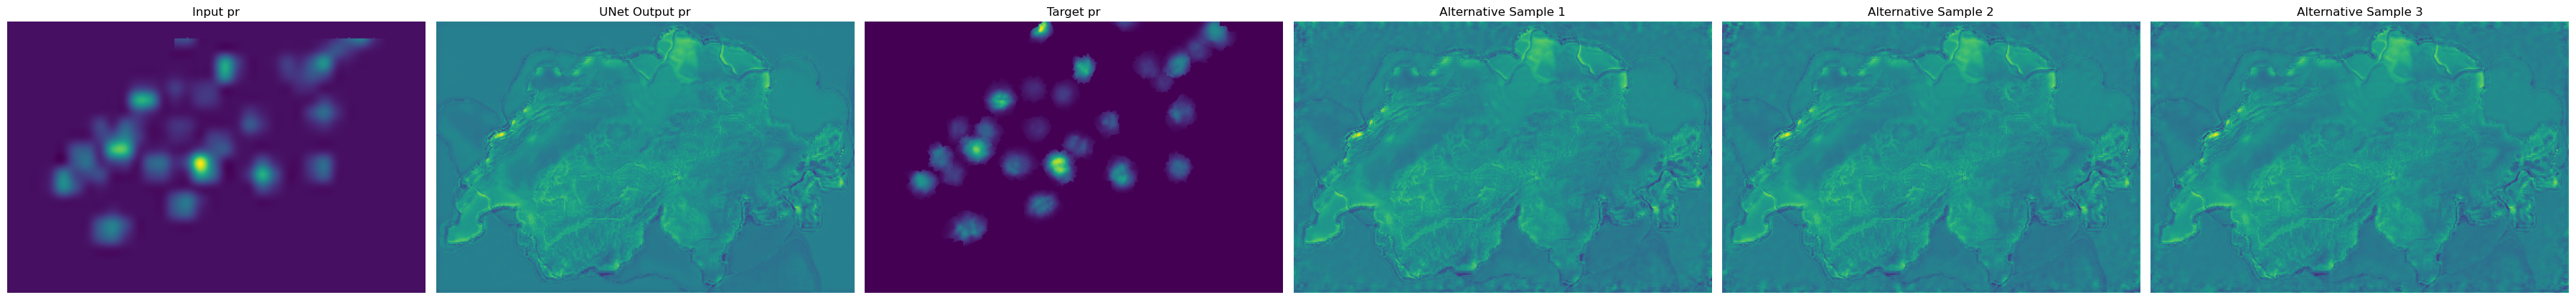

In [24]:
with open("../Training_Chronological_Dataset/RhiresD_scaling_params_chronological.json") as f:
    pr_params = json.load(f)
with open("../Training_Chronological_Dataset/TabsD_scaling_params_chronological.json") as f:
    temp_params = json.load(f)
with open("../Training_Chronological_Dataset/TminD_scaling_params_chronological.json") as f:
    temp_min_params = json.load(f)
with open("../Training_Chronological_Dataset/TmaxD_scaling_params_chronological.json") as f:
    temp_max_params = json.load(f)

def denorm_pr(x):
    # Min-max
    return x * (pr_params["max"] - pr_params["min"]) + pr_params["min"]

def denorm_temp(x, params):
    # z
    return x * params["std"] + params["mean"]

# Denorming
images = [
    denorm_pr(input_sample[0, 0].cpu().numpy()),       # Input pr
    denorm_pr(unet_out[0, 0].cpu().numpy()),           # UNet Output pr
    denorm_pr(target_sample[0, 0].cpu().numpy())       # Target pr
]
titles = ["Input pr", "UNet Output pr", "Target pr"]

for i, alt_sample in enumerate(alternative_samples):
    images.append(denorm_pr(alt_sample[0, 0].cpu().numpy()))
    titles.append(f"Alternative Sample {i+1}")

n_images = len(images)
fig, axes = plt.subplots(1, n_images, figsize=(6 * n_images, 5))

for ax, img, title in zip(axes, images, titles):
    ax.imshow(np.flipud(img), cmap='viridis')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()